In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, mean_squared_log_error
from tensorflow.keras import layers, models


In [5]:
# Загрузка и предобработка данных
def load_and_preprocess_data():
    ds, info = tfds.load('svhn_cropped', with_info=True, as_supervised=True)
    train_ds, test_ds = ds['train'], ds['test']

    def filter_classes(image, label):
        return tf.reduce_any(tf.equal(label, [0, 2, 4, 6, 8]))

    def to_grayscale(image, label):
        image = tf.image.rgb_to_grayscale(image)
        return image, label

    train_ds = train_ds.filter(filter_classes).map(to_grayscale).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    test_ds = test_ds.filter(filter_classes).map(to_grayscale).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    return train_ds, test_ds

train_ds, test_ds = load_and_preprocess_data()

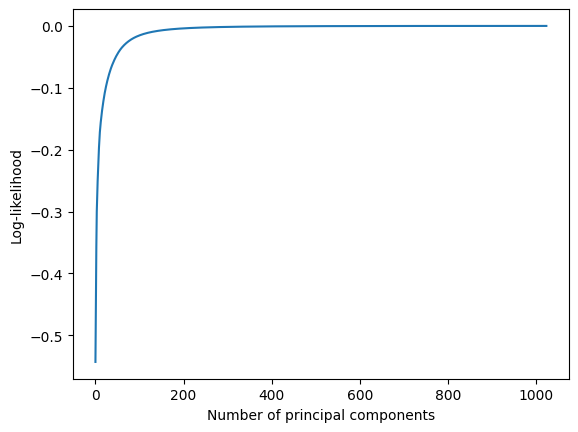

In [6]:
# PCA и график логарифмического правдоподобия
def plot_log_likelihood(train_ds):
    images = []
    for image_batch, _ in train_ds:
        images.append(image_batch.numpy())
    images = np.concatenate(images, axis=0)
    images_flat = images.reshape(images.shape[0], -1)
    
    pca = PCA()
    pca.fit(images_flat)
    log_likelihood = np.log(np.cumsum(pca.explained_variance_ratio_))

    plt.figure()
    plt.plot(log_likelihood)
    plt.xlabel('Number of principal components')
    plt.ylabel('Log-likelihood')
    plt.show()

    optimal_components = np.argmax(log_likelihood >= np.log(0.95)) + 1
    return optimal_components

latent_dim = plot_log_likelihood(train_ds)

In [ ]:
# Определение и обучение автокодировщика
def build_autoencoder(latent_dim):
    encoder_input = layers.Input(shape=(32, 32, 1))
    encoder = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(latent_dim, activation='relu'),
    ])
    encoder_output = encoder(encoder_input)

    decoder_input = layers.Input(shape=(latent_dim,))
    decoder = models.Sequential([
        layers.Dense(8 * 8 * 128, activation='relu'),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same'),
    ])
    decoder_output = decoder(decoder_input)

    autoencoder = models.Model(encoder_input, decoder(encoder_output))
    autoencoder.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
    return autoencoder

autoencoder = build_autoencoder(latent_dim)
history = autoencoder.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
   1054/Unknown 12s 9ms/step - loss: 0.9198

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1056/1056 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.9198 - val_loss: 0.8709
Epoch 2/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.9164 - val_loss: 0.8709
Epoch 3/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.9164 - val_loss: 0.8709
Epoch 4/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.9164 - val_loss: 0.8709
Epoch 5/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.9164 - val_loss: 0.8709
Epoch 6/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.9164 - val_loss: 0.8709
Epoch 7/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.9164 - val_loss: 0.8709
Epoch 8/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.9164 - val_loss: 0.8709
Epoch 9/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.9164 - val_loss: 0.8709
Epoch 10/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.9164 - val_loss: 0.8709
Epoch 11/20
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.9164 - val_loss: 0.8709
Epoch 12/20
1056/10

In [ ]:
# Визуализация реконструированных изображений
def visualize_reconstructions(autoencoder, test_ds):
    for image_batch, _ in test_ds.take(1):
        reconstructed = autoencoder.predict(image_batch)
        n = 10
        plt.figure(figsize=(20, 4))
        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(image_batch[i].numpy().squeeze(), cmap='gray')
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.show()

visualize_reconstructions(autoencoder, test_ds)

In [ ]:
# Step 4: Evaluate autoencoder
def evaluate_autoencoder(autoencoder, test_ds):
    msle = 0
    count = 0
    for image_batch, _ in test_ds:
        reconstructed = autoencoder.predict(image_batch)
        msle += mean_squared_log_error(image_batch.numpy().flatten(), reconstructed.flatten())
        count += 1
    msle /= count
    return msle

msle = evaluate_autoencoder(autoencoder, test_ds)
print(f"MSLE: {msle}")


In [ ]:
# Step 5: Visualize latent space
def visualize_latent_space(autoencoder, train_ds):
    encoder = autoencoder.layers[0]
    images = []
    labels = []
    for image_batch, label_batch in train_ds:
        images.append(image_batch.numpy())
        labels.append(label_batch.numpy())
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    latent_representations = encoder.predict(images)
    
    plt.figure()
    scatter = plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.xlabel('Latent Feature 1')
    plt.ylabel('Latent Feature 2')
    plt.show()

visualize_latent_space(autoencoder, train_ds)

In [ ]:
# Step 6: Binary classification using kNN
def classify_and_evaluate_knn(train_ds, test_ds, use_latent_space=True):
    encoder = autoencoder.layers[0]
    
    def get_data(ds):
        images = []
        labels = []
        for image_batch, label_batch in ds:
            images.append(image_batch.numpy())
            labels.append(label_batch.numpy())
        images = np.concatenate(images, axis=0)
        labels = np.concatenate(labels, axis=0)
        return images, labels
    
    train_images, train_labels = get_data(train_ds)
    test_images, test_labels = get_data(test_ds)
    
    if use_latent_space:
        train_images = encoder.predict(train_images)
        test_images = encoder.predict(test_images)
    else:
        train_images = train_images.reshape(train_images.shape[0], -1)
        test_images = test_images.reshape(test_images.shape[0], -1)
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(train_images, train_labels)
    predictions = knn.predict(test_images)
    f1 = f1_score(test_labels, predictions, average='macro')
    return f1, knn

f1_latent, knn_latent = classify_and_evaluate_knn(train_ds, test_ds, use_latent_space=True)
f1_all, knn_all = classify_and_evaluate_knn(train_ds, test_ds, use_latent_space=False)
print(f"F1 Score (Latent): {f1_latent}, F1 Score (All Features): {f1_all}")


In [ ]:
# Step 7: ROC curves
def plot_roc_curves(knn_latent, knn_all, test_ds):
    encoder = autoencoder.layers[0]
    test_images, test_labels = get_data(test_ds)
    
    test_images_latent = encoder.predict(test_images)
    test_images_flat = test_images.reshape(test_images.shape[0], -1)
    
    latent_probs = knn_latent.predict_proba(test_images_latent)[:, 1]
    all_probs = knn_all.predict_proba(test_images_flat)[:, 1]
    
    fpr_latent, tpr_latent, _ = roc_curve(test_labels, latent_probs)
    fpr_all, tpr_all, _ = roc_curve(test_labels, all_probs)
    
    plt.figure()
    plt.plot(fpr_latent, tpr_latent, label='Latent Features')
    plt.plot(fpr_all, tpr_all, label='All Features')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

plot_roc_curves(knn_latent, knn_all, test_ds)


In [ ]:
# Step 8: Decision boundaries
def plot_decision_boundaries(knn_latent, test_ds):
    encoder = autoencoder.layers[0]
    test_images, test_labels = get_data(test_ds)
    latent_representations = encoder.predict(test_images)
    
    x_min, x_max = latent_representations[:, 0].min() - 1, latent_representations[:, 0].max() + 1
    y_min, y_max = latent_representations[:, 1].min() - 1, latent_representations[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = knn_latent.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.8)
    scatter = plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c=test_labels, edgecolor='k', marker='o')
    plt.colorbar(scatter)
    plt.xlabel('Latent Feature 1')
    plt.ylabel('Latent Feature 2')
    plt.title('Decision Boundaries')
    plt.show()

plot_decision_boundaries(knn_latent, test_ds)

In [ ]:
# Step 9: Find image with highest reconstruction error
def find_max_reconstruction_error(autoencoder, test_ds):
    max_error = -np.inf
    max_error_image = None
    max_error_reconstructed = None
    
    for image_batch, _ in test_ds:
        reconstructed = autoencoder.predict(image_batch)
        errors = np.sum((image_batch.numpy() - reconstructed) ** 2, axis=(1, 2, 3))
        max_idx = np.argmax(errors)
        if errors[max_idx] > max_error:
            max_error = errors[max_idx]
            max_error_image = image_batch[max_idx].numpy()
            max_error_reconstructed = reconstructed[max_idx]
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(max_error_image.squeeze(), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Image')
    plt.imshow(max_error_reconstructed.squeeze(), cmap='gray')
    plt.show()

find_max_reconstruction_error(autoencoder, test_ds)
